In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set the path to your unzipped files
data_path = r"C:\Users\Reyes\Downloads"

# Function to load data with proper numeric conversion
def load_pharma_data(filename):
    path = f"{data_path}\\{filename}"
    try:
        # First try reading with automatic type inference
        df = pd.read_csv(path)
        
        # Convert all medication columns to numeric, coercing errors
        for col in df.columns:
            if col not in ['datum', 'Year', 'Month', 'Hour', 'Weekday Name']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        print(f"Successfully loaded {filename}")
        return df
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")
        return None

# Load all datasets
daily_df = load_pharma_data("salesdaily.csv")
hourly_df = load_pharma_data("saleshourly.csv")
weekly_df = load_pharma_data("salesweekly.csv")
monthly_df = load_pharma_data("salesmonthly.csv")

# Medication categories
med_categories = {
    'M01AB': 'Anti-inflammatory products',
    'M01AE': 'Anti-inflammatory products',
    'N02BA': 'Other analgesics',
    'N02BE': 'Other analgesics',
    'N05B': 'Anxiolytics',
    'N05C': 'Hypnotics and sedatives',
    'R03': 'Anti-asthmatics',
    'R06': 'Antihistamines'
}

# Data Preparation with numeric checks
def prepare_data(df, date_col='datum'):
    if df is None:
        return None
    
    df = df.copy()
    
    # Convert date column
    try:
        df[date_col] = pd.to_datetime(df[date_col])
    except:
        print(f"Could not convert date column in dataframe")
        return None
    
    # Set index and ensure numeric data
    df.set_index(date_col, inplace=True)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols]  # Keep only numeric columns
    
    return df

# Prepare all datasets
dfs = {
    'hourly': prepare_data(hourly_df),
    'daily': prepare_data(daily_df),
    'weekly': prepare_data(weekly_df),
    'monthly': prepare_data(monthly_df)
}

# 1. Basic Data Inspection
print("\nAvailable datasets:")
for freq, df in dfs.items():
    if df is not None:
        print(f"{freq}: {df.shape[0]} records from {df.index.min()} to {df.index.max()}")
        print(f"Medications: {', '.join([c for c in df.columns if c in med_categories])}")
    else:
        print(f"{freq}: Not available")


Successfully loaded salesdaily.csv
Successfully loaded saleshourly.csv
Successfully loaded salesweekly.csv
Successfully loaded salesmonthly.csv

Available datasets:
hourly: 50532 records from 2014-01-02 08:00:00 to 2019-10-08 19:00:00
Medications: M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06
daily: 2106 records from 2014-01-02 00:00:00 to 2019-10-08 00:00:00
Medications: M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06
weekly: 302 records from 2014-01-05 00:00:00 to 2019-10-13 00:00:00
Medications: M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06
monthly: 70 records from 2014-01-31 00:00:00 to 2019-10-31 00:00:00
Medications: M01AB, M01AE, N02BA, N02BE, N05B, N05C, R03, R06


plot:


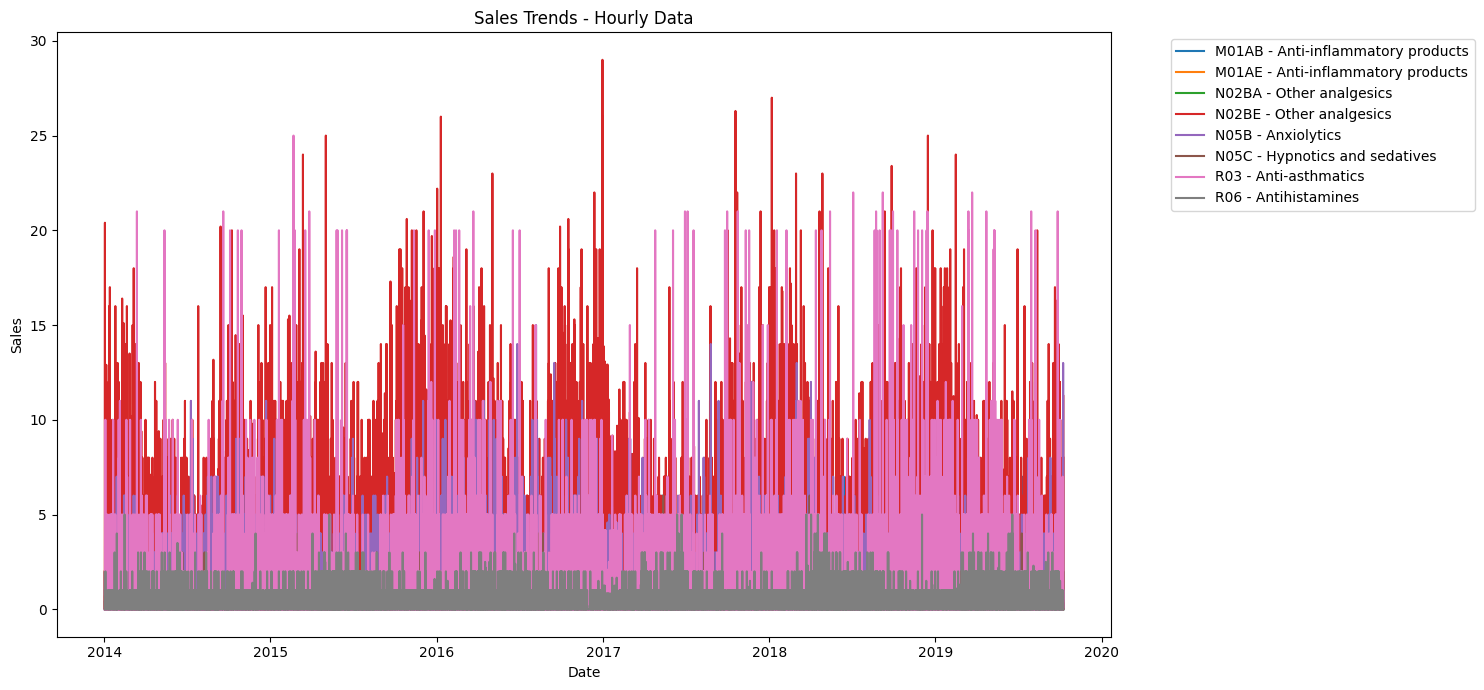

plot:


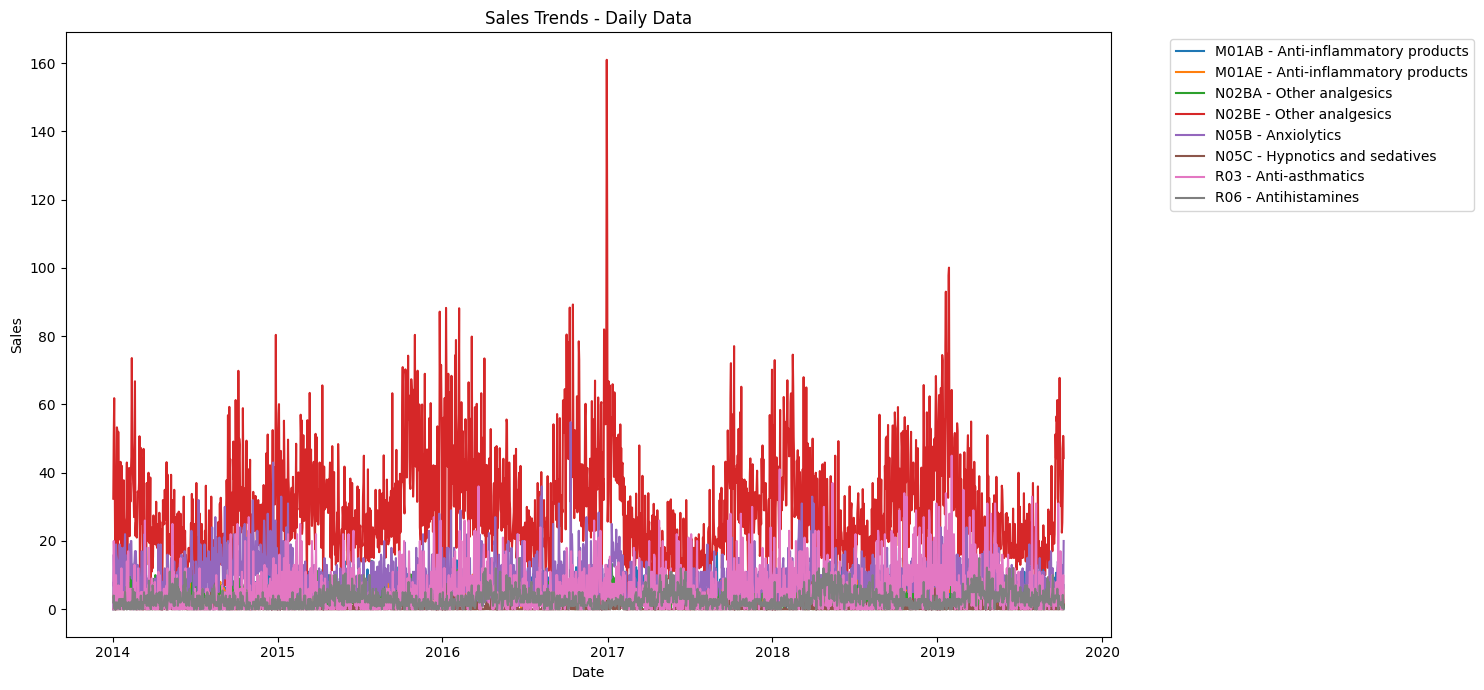

plot:


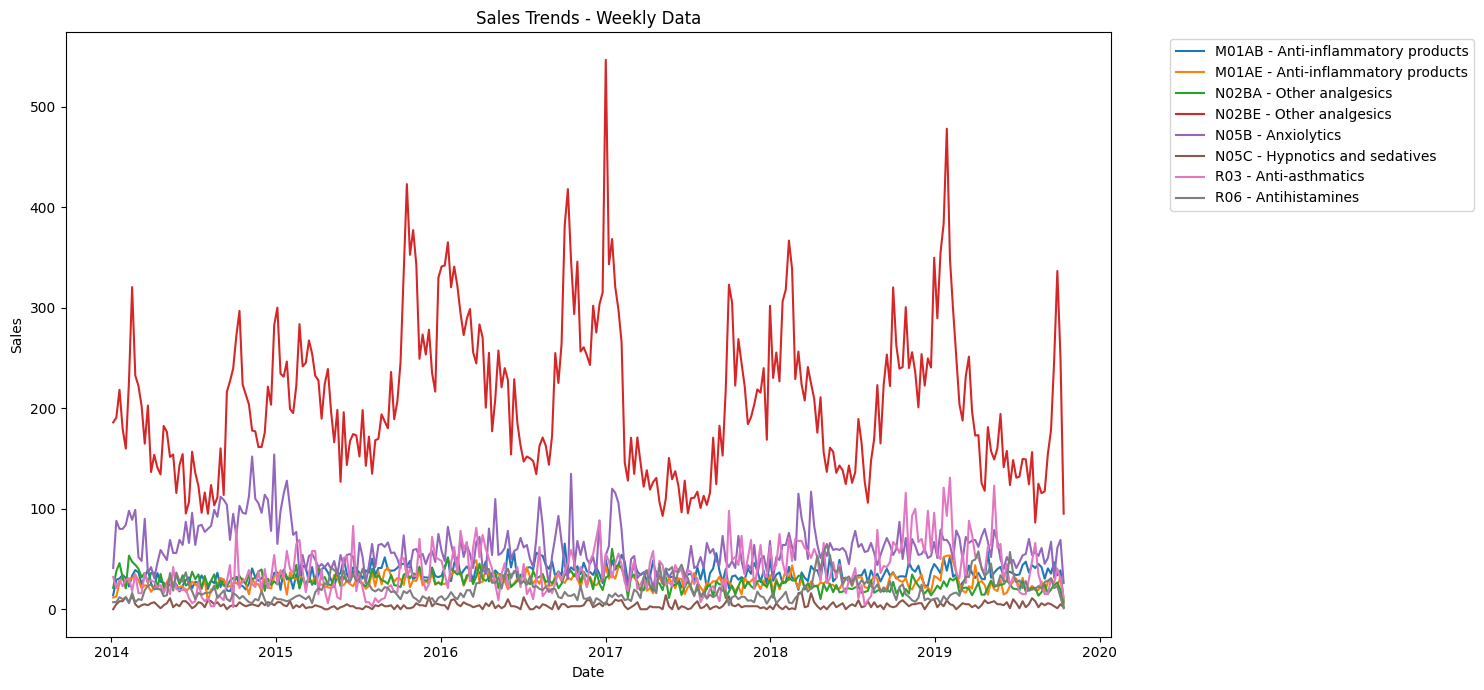

plot:


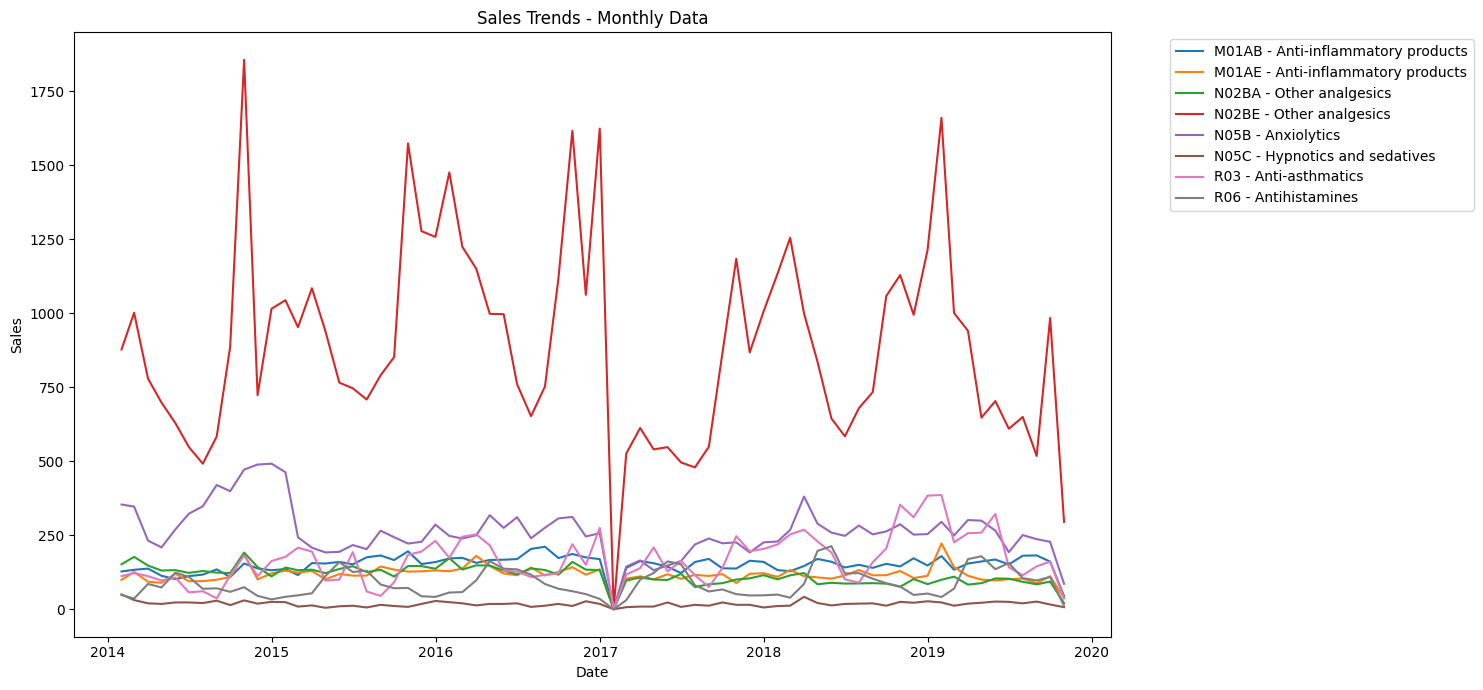

In [10]:
# 2. Cleaned Data Visualization
def plot_medication_trends(df, title):
    if df is None:
        return
        
    plt.figure(figsize=(15, 7))
    for med in df.columns:
        if med in med_categories:
            plt.plot(df.index, df[med], label=f"{med} - {med_categories[med]}")
    plt.title(f'Sales Trends - {title}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot trends for available datasets
for freq, df in dfs.items():
    if df is not None:
        print("plot:")
        plot_medication_trends(df, f'{freq.capitalize()} Data')

Successfully loaded salesdaily.csv

Statistical Summary of Drug Sales:
Drug Code                   Category      Mean  Median  Mode      Range  Min        Max
    M01AB Anti-inflammatory products  5.033683    4.99   4.0  17.340000  0.0  17.340000
    M01AE Anti-inflammatory products  3.895830    3.67   3.0  14.463000  0.0  14.463000
    N02BA           Other analgesics  3.880441    3.50   3.0  16.000000  0.0  16.000000
    N02BE           Other analgesics 29.917095   26.90  15.0 161.000000  0.0 161.000000
     N05B                Anxiolytics  8.853627    8.00   6.0  54.833333  0.0  54.833333
     N05C    Hypnotics and sedatives  0.593522    0.00   0.0   9.000000  0.0   9.000000
      R03            Anti-asthmatics  5.512262    4.00   0.0  45.000000  0.0  45.000000
      R06             Antihistamines  2.900198    2.00   2.0  15.000000  0.0  15.000000


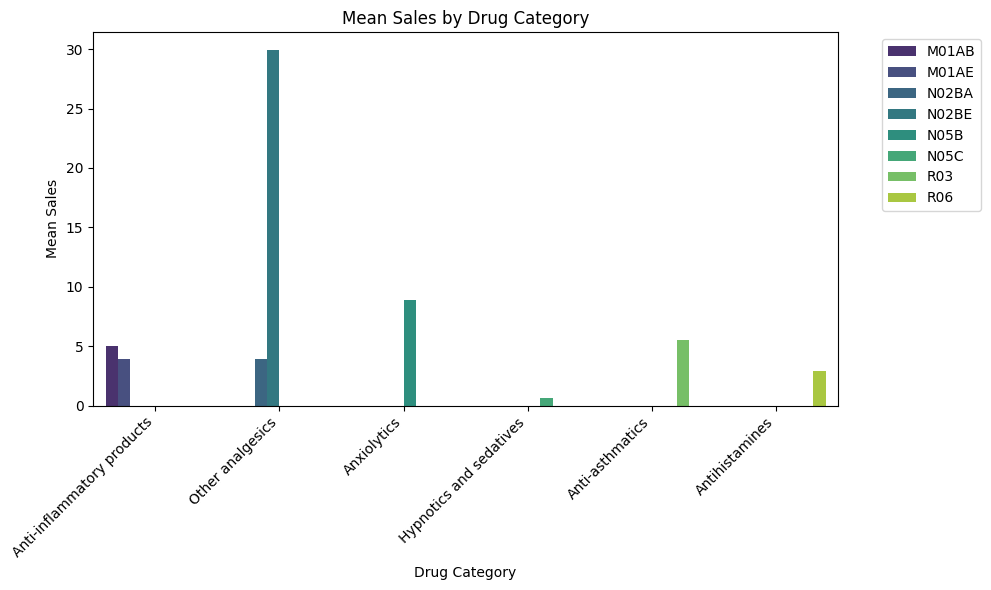

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset (using your existing function)
def load_pharma_data(filename):
    path = f"{data_path}\\{filename}"
    try:
        df = pd.read_csv(path)
        for col in df.columns:
            if col not in ['datum', 'Year', 'Month', 'Hour', 'Weekday Name']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Successfully loaded {filename}")
        return df
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")
        return None

# Load daily data (or choose another frequency)
daily_df = load_pharma_data("salesdaily.csv")

# Medication categories (from your reference)
med_categories = {
    'M01AB': 'Anti-inflammatory products',
    'M01AE': 'Anti-inflammatory products',
    'N02BA': 'Other analgesics',
    'N02BE': 'Other analgesics',
    'N05B': 'Anxiolytics',
    'N05C': 'Hypnotics and sedatives',
    'R03': 'Anti-asthmatics',
    'R06': 'Antihistamines'
}

# Prepare data (keep only numeric columns)
def prepare_data(df, date_col='datum'):
    if df is None:
        return None
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    return df[numeric_cols]

daily_data = prepare_data(daily_df)

# Calculate statistics for each drug
def calculate_stats(df):
    stats = []
    for med in df.columns:
        if med in med_categories:
            sales = df[med].dropna()  # Remove missing values
            stats.append({
                'Drug Code': med,
                'Category': med_categories[med],
                'Mean': sales.mean(),
                'Median': sales.median(),
                'Mode': sales.mode()[0],  # Take the first mode if multiple
                'Range': sales.max() - sales.min(),
                'Min': sales.min(),
                'Max': sales.max()
            })
    return pd.DataFrame(stats)

# Generate stats
stats_df = calculate_stats(daily_data)

# Display the results
print("\nStatistical Summary of Drug Sales:")
print(stats_df.to_string(index=False))

# Visualize mean sales by category
plt.figure(figsize=(10, 6))
sns.barplot(data=stats_df, x='Category', y='Mean', hue='Drug Code', palette='viridis')
plt.title('Mean Sales by Drug Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean Sales')
plt.xlabel('Drug Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Successfully loaded salesdaily.csv

Analyzing seasonal trends for M01AB - Anti-inflammatory products


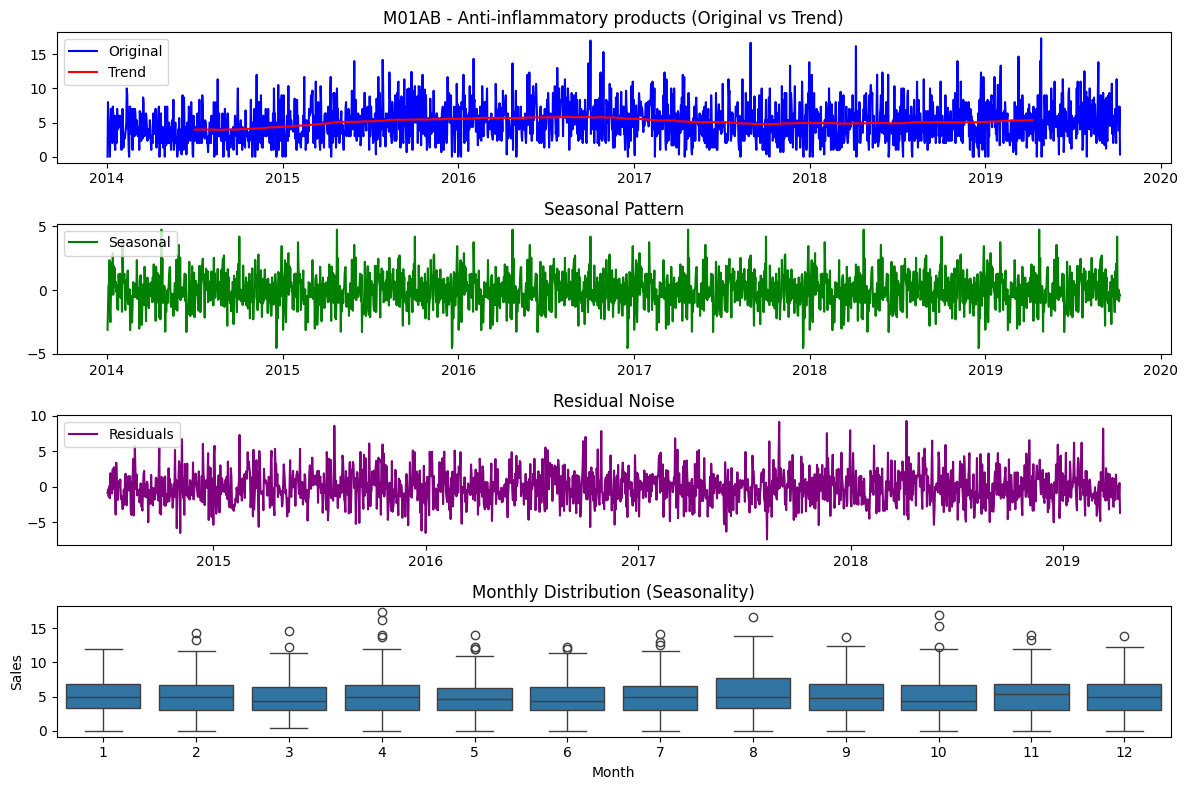


Analyzing seasonal trends for M01AE - Anti-inflammatory products


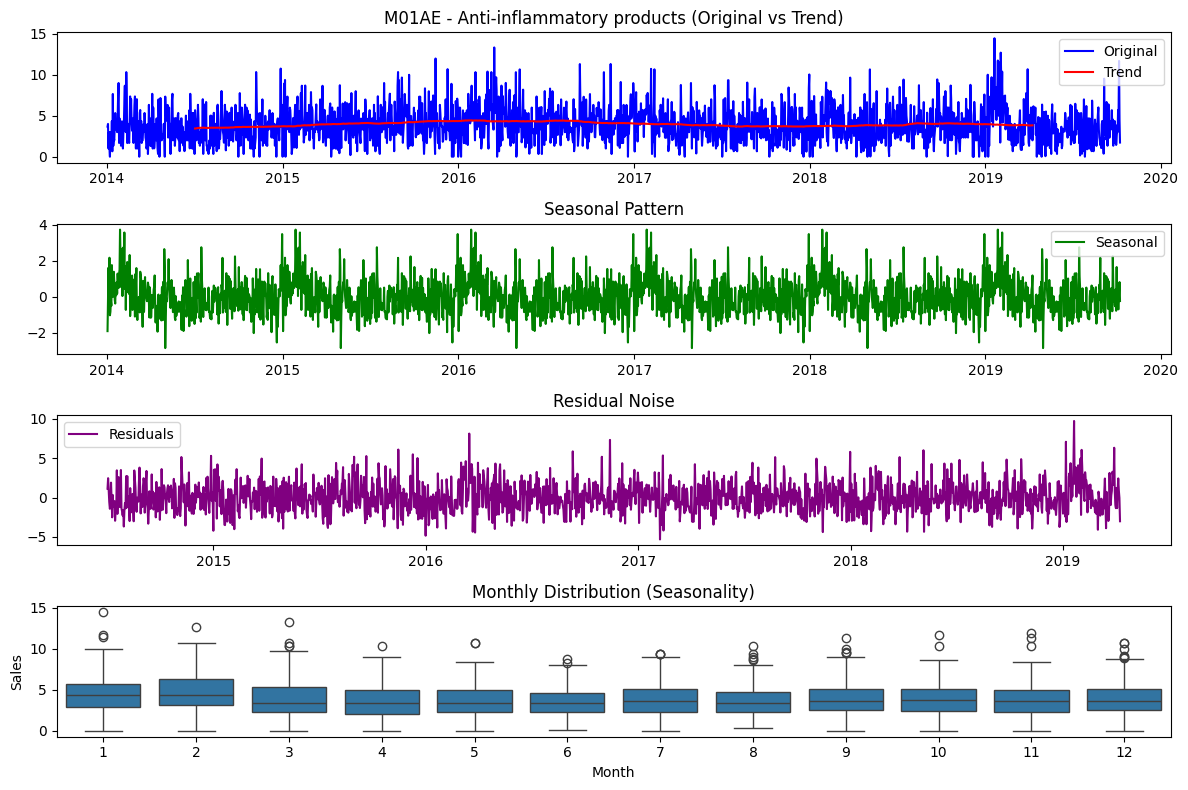


Analyzing seasonal trends for N02BA - Other analgesics


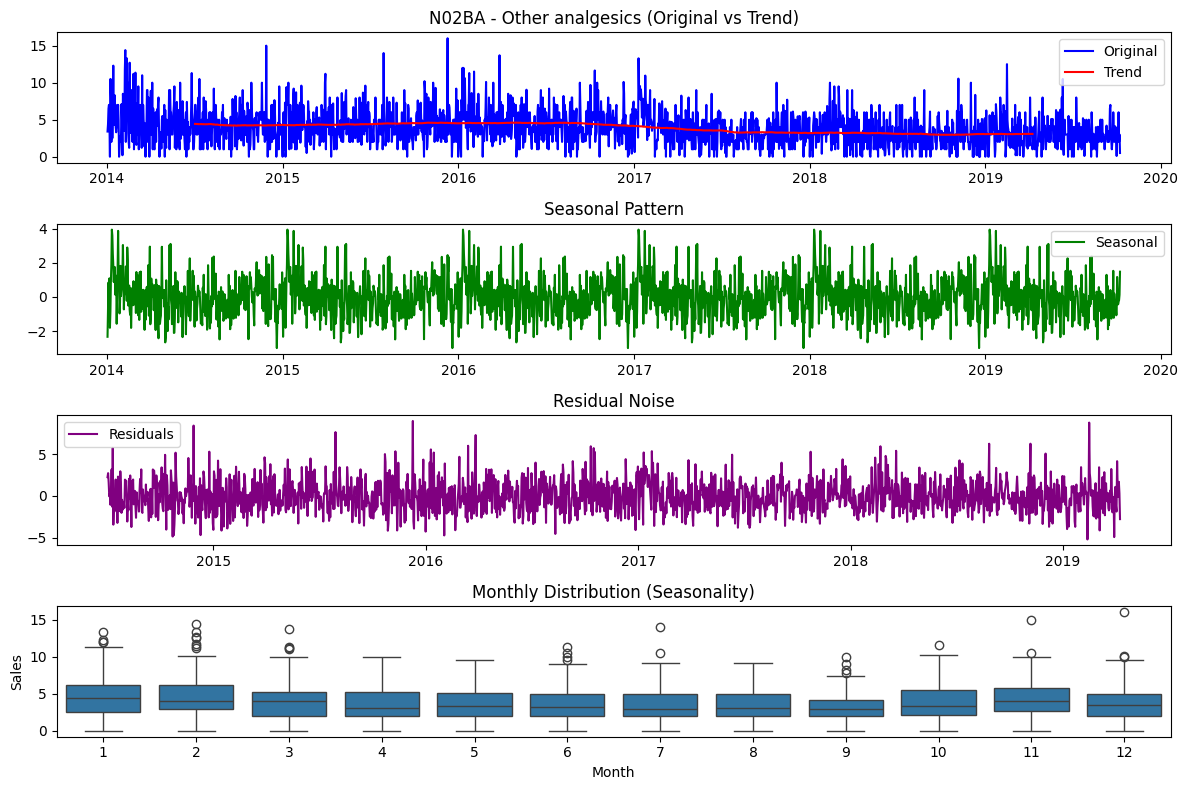


Analyzing seasonal trends for N02BE - Other analgesics


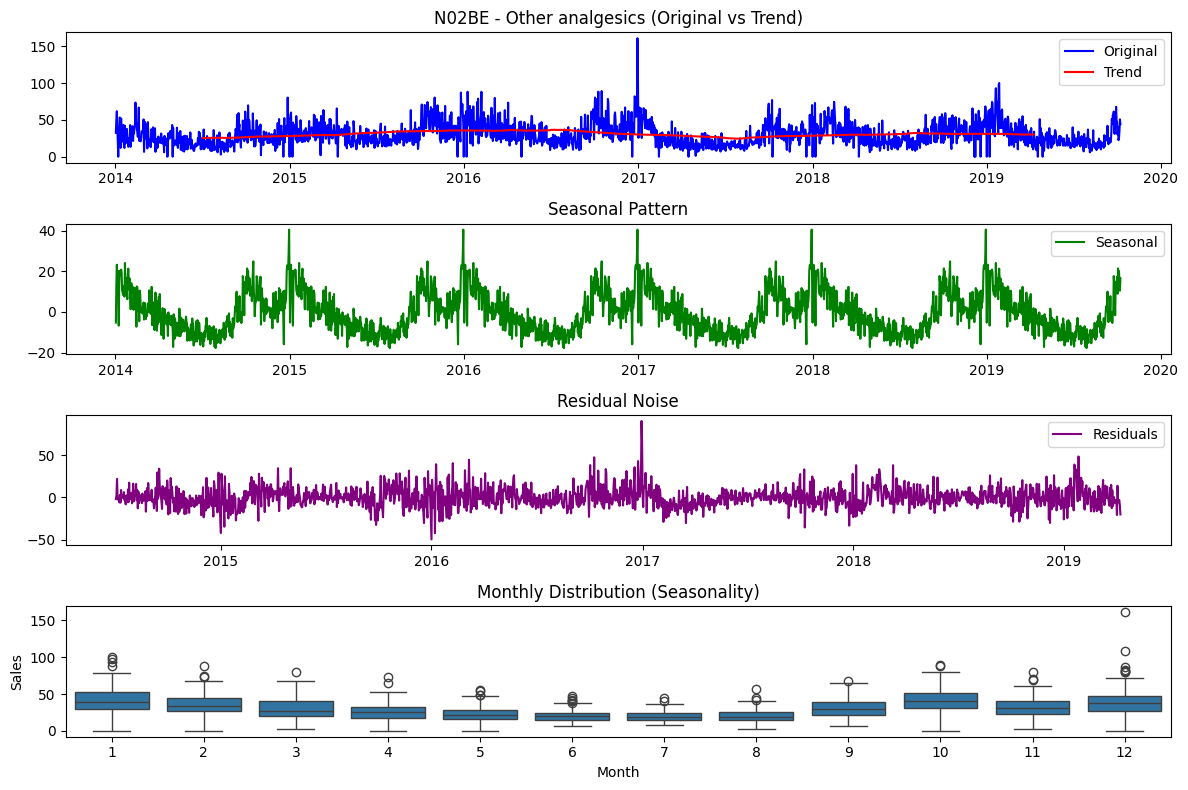


Analyzing seasonal trends for N05B - Anxiolytics


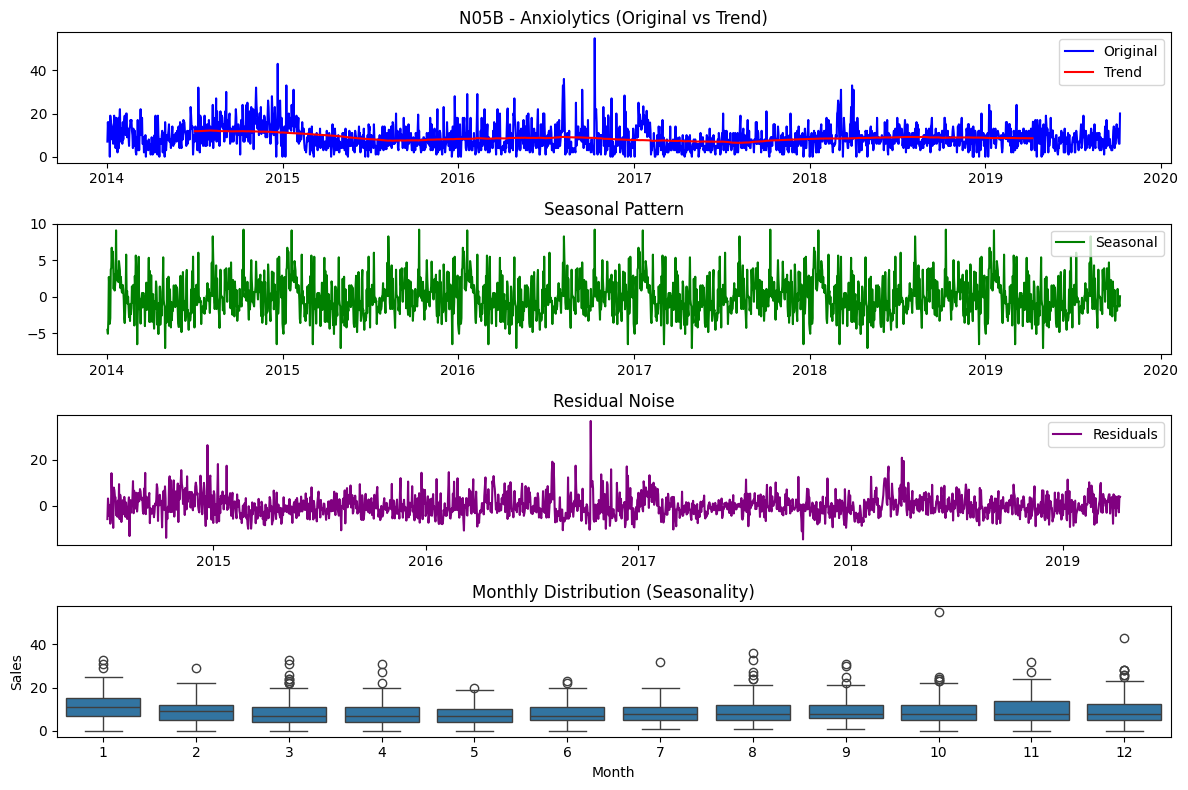


Analyzing seasonal trends for N05C - Hypnotics and sedatives


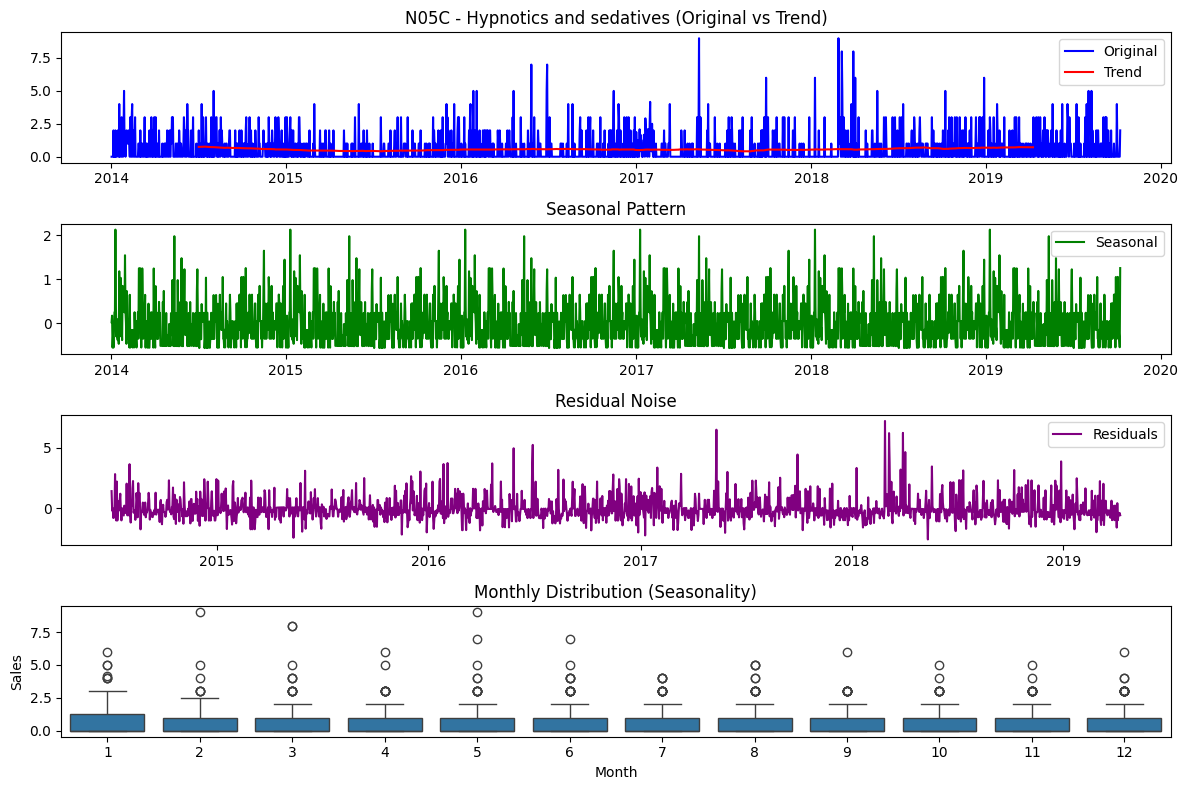


Analyzing seasonal trends for R03 - Anti-asthmatics


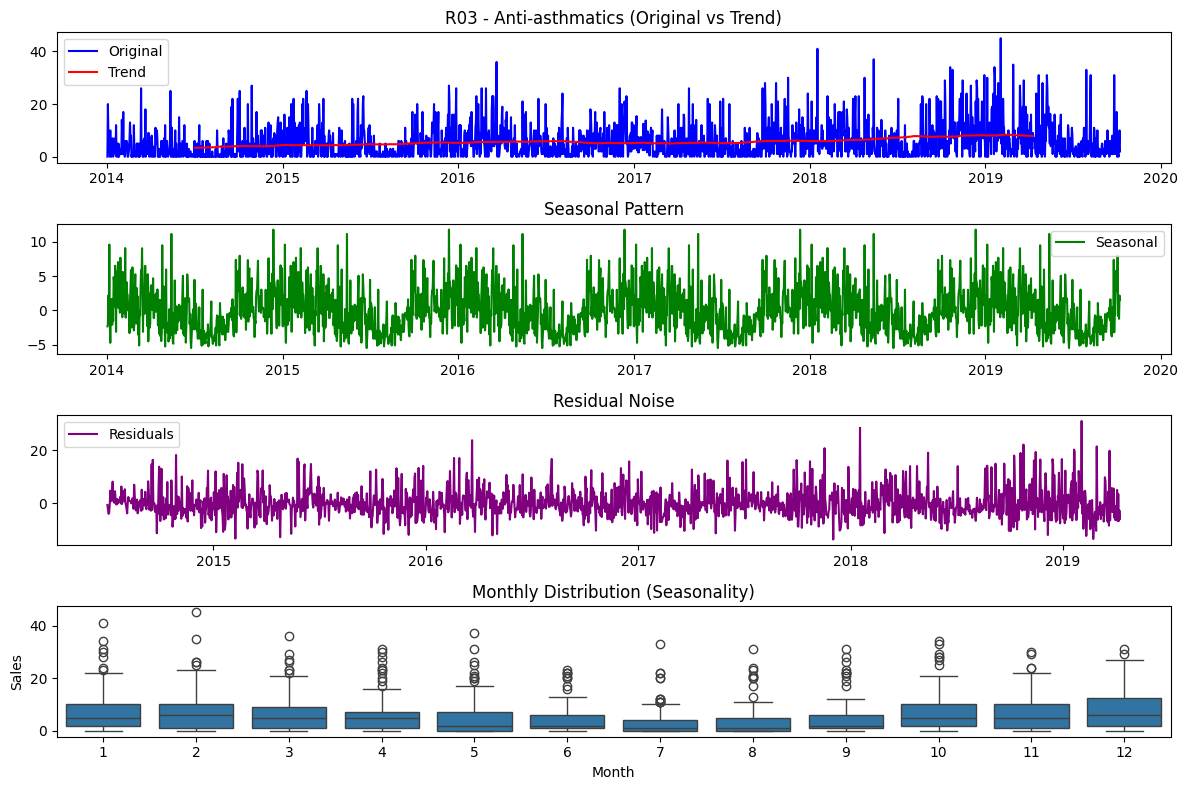


Analyzing seasonal trends for R06 - Antihistamines


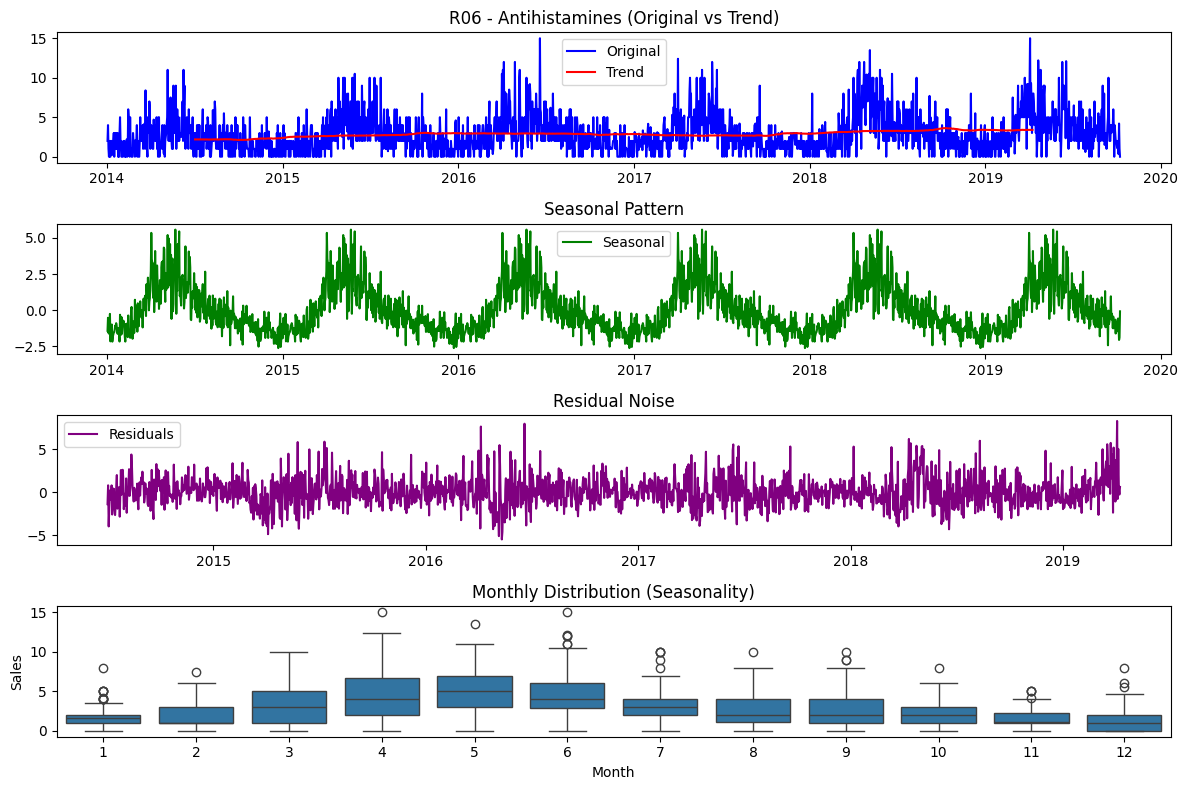

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Load and prepare data (using your existing functions)
daily_df = load_pharma_data("salesdaily.csv")
daily_data = prepare_data(daily_df)

# Select drugs for analysis (modify as needed)
target_drugs = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']  # Example: Analgesics, Anti-asthmatics, Anxiolytics

# Time-series decomposition for each drug
def decompose_drug_sales(df, drug_code, freq=365):  # freq=365 for yearly seasonality
    if drug_code not in df.columns:
        print(f"{drug_code} not found in dataset.")
        return None
    
    # Resample to daily frequency (fill missing dates if needed)
    ts = df[drug_code].dropna().asfreq('D').fillna(method='ffill')
    
    # Decompose (additive or multiplicative)
    try:
        decomposition = seasonal_decompose(ts, model='additive', period=freq)
        return decomposition
    except Exception as e:
        print(f"Error decomposing {drug_code}: {str(e)}")
        return None

# Plot decomposition for each drug
for drug in target_drugs:
    if drug in daily_data.columns:
        print(f"\nAnalyzing seasonal trends for {drug} - {med_categories[drug]}")
        decomp = decompose_drug_sales(daily_data, drug)
        
        if decomp:
            plt.figure(figsize=(12, 8))
            
            # Original vs Trend
            plt.subplot(4, 1, 1)
            plt.plot(decomp.observed, label='Original', color='blue')
            plt.plot(decomp.trend, label='Trend', color='red')
            plt.legend()
            plt.title(f'{drug} - {med_categories[drug]} (Original vs Trend)')
            
            # Seasonal Component
            plt.subplot(4, 1, 2)
            plt.plot(decomp.seasonal, label='Seasonal', color='green')
            plt.legend()
            plt.title('Seasonal Pattern')
            
            # Residuals
            plt.subplot(4, 1, 3)
            plt.plot(decomp.resid, label='Residuals', color='purple')
            plt.legend()
            plt.title('Residual Noise')
            
            # Yearly seasonality (aggregated)
            plt.subplot(4, 1, 4)
            sns.boxplot(x=daily_data.index.month, y=daily_data[drug])
            plt.title('Monthly Distribution (Seasonality)')
            plt.xlabel('Month')
            plt.ylabel('Sales')
            
            plt.tight_layout()
            plt.show()
    else:
        print(f"{drug} not found in dataset.")

Successfully loaded salesmonthly.csv


Text(0.5, 1.0, 'Autocorrelation (Seasonality Check)')

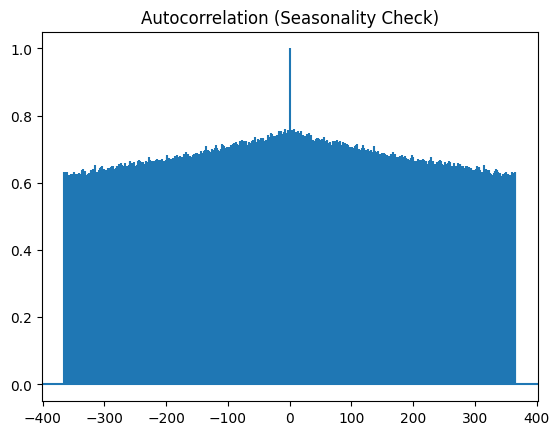

In [5]:
# Analyze weekly/monthly data instead of daily
monthly_data = prepare_data(load_pharma_data("salesmonthly.csv"))
decomp_monthly = decompose_drug_sales(monthly_data, 'N02BA', freq=12)  # 12 for yearly (monthly data)

from statsmodels.tsa.stattools import acf, pacf
# Autocorrelation plot for lags
plt.acorr(daily_data['N02BA'].dropna(), maxlags=365)
plt.title('Autocorrelation (Seasonality Check)')

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and prepare data (using your existing functions)
daily_data = prepare_data(load_pharma_data("salesdaily.csv"))

# Define drug categories (from your reference)
med_categories = {
    'M01AB': 'Anti-inflammatory',
    'M01AE': 'Anti-inflammatory',
    'N02BA': 'Analgesics',
    'N02BE': 'Analgesics',
    'N05B': 'Anxiolytics',
    'N05C': 'Hypnotics',
    'R03': 'Anti-asthmatics',
    'R06': 'Antihistamines'
}

# Resample data to monthly (for smoother trends)
monthly_data = daily_data.resample('M').sum()

Successfully loaded salesdaily.csv


#### ARIMA

Successfully loaded salesdaily.csv


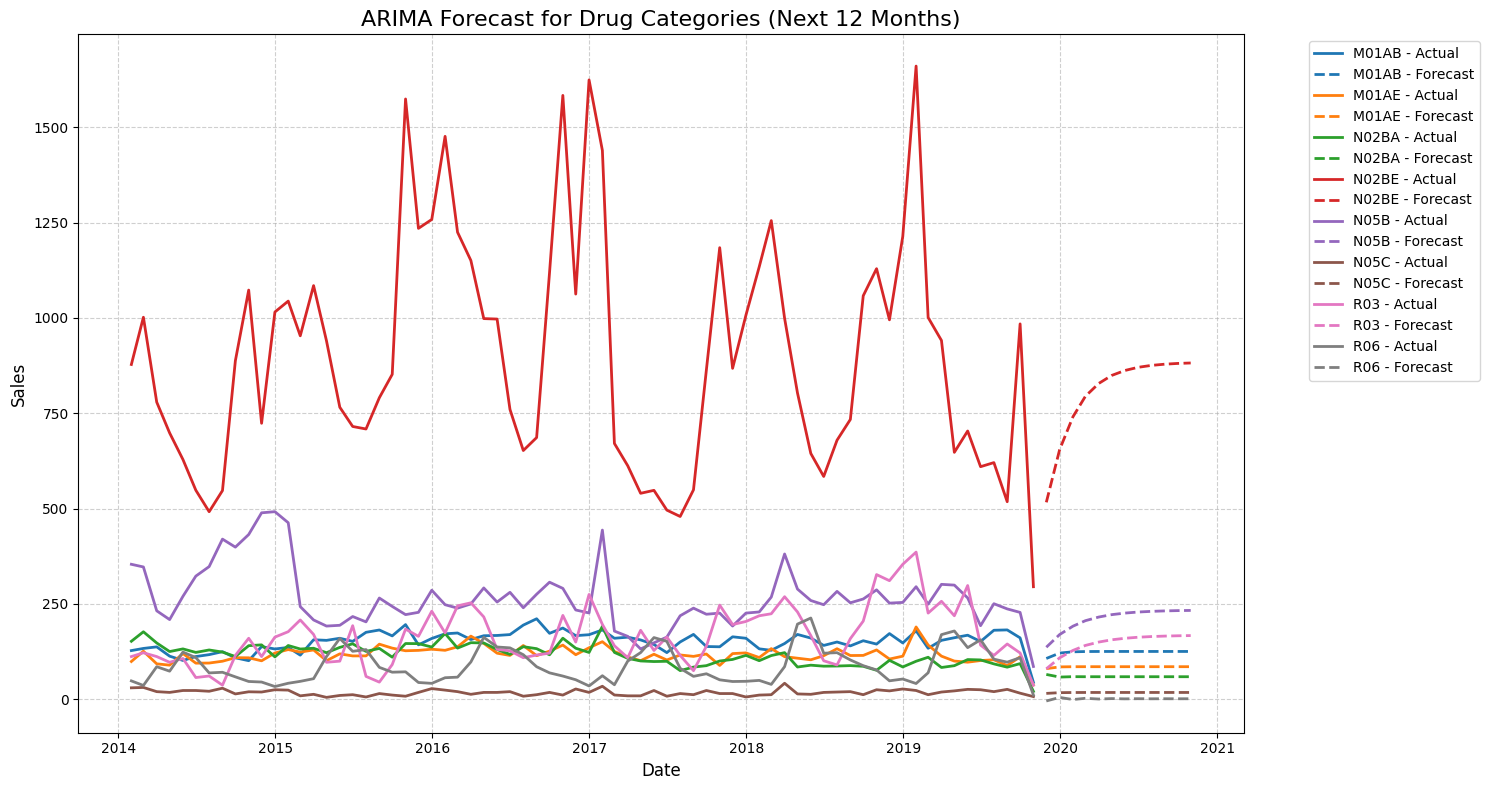

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load and prepare data (using your existing functions)
daily_data = prepare_data(load_pharma_data("salesdaily.csv"))
monthly_data = daily_data.resample('M').sum()

# Define a color palette for each drug
drug_colors = {
    'M01AB': '#1f77b4',  # Blue
    'M01AE': '#ff7f0e',  # Orange
    'N02BA': '#2ca02c',  # Green
    'N02BE': '#d62728',  # Red
    'N05B': '#9467bd',   # Purple
    'N05C': '#8c564b',   # Brown
    'R03': '#e377c2',    # Pink
    'R06': '#7f7f7f'     # Gray
}

# Forecast and plot with unique colors
plt.figure(figsize=(15, 8))

for drug in med_categories:
    ts = monthly_data[drug].dropna()
    if len(ts) > 12:  # Minimum data requirement for ARIMA
        # Fit ARIMA model
        model = ARIMA(ts, order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=12)  # Predict next 12 months
        
        # Plot actual data
        plt.plot(ts.index, ts, 
                label=f'{drug} - Actual', 
                color=drug_colors[drug], 
                linestyle='-', 
                linewidth=2)
        
        # Plot forecasted data (dashed line with same color)
        forecast_index = pd.date_range(ts.index[-1], periods=13, freq='M')[1:]
        plt.plot(forecast_index, forecast, 
                label=f'{drug} - Forecast', 
                color=drug_colors[drug], 
                linestyle='--', 
                linewidth=2)

# Customize plot
plt.title('ARIMA Forecast for Drug Categories (Next 12 Months)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### XGBoost

In [14]:
def forecast_xgboost(ts, test_size=0.2):
    # Create features: lags and time-based
    df = pd.DataFrame(ts)
    for lag in range(1, 4):
        df[f'lag_{lag}'] = df[ts.name].shift(lag)
    df['month'] = df.index.month
    df.dropna(inplace=True)
    
    # Split data
    X = df.drop(columns=ts.name)
    y = df[ts.name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    # Train XGBoost
    model = XGBRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Evaluate
    mae = mean_absolute_error(y_test, predictions)
    print(f'{ts.name} - MAE: {mae:.2f}')
    return predictions

# Forecast for each drug
for drug in med_categories:
    ts = monthly_data[drug].dropna()
    if len(ts) > 10:  # Minimum data requirement
        forecast_xgboost(ts)
        

M01AB - MAE: 27.04
M01AE - MAE: 20.41
N02BA - MAE: 15.39
N02BE - MAE: 212.86
N05B - MAE: 44.88
N05C - MAE: 5.93
R03 - MAE: 96.59
R06 - MAE: 24.84
